In [1]:
%matplotlib inline

from __future__ import print_function
import itertools
import matplotlib
import numpy as np
import sys
import tensorflow as tf
import collections

import sklearn.pipeline
import sklearn.preprocessing

if "../" not in sys.path:
  sys.path.append("../") 
import plotting

from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [2]:
from lib_robotis_hack import *

D = USB2Dynamixel_Device(dev_name="/dev/ttyUSB0",baudrate=1000000)
s_list = find_servos(D)
s1 = Robotis_Servo(D,s_list[0])
s2 = Robotis_Servo(D,s_list[1])

Scanning for Servos.

 FOUND A SERVO @ ID 2


 FOUND A SERVO @ ID 3



In [3]:
observation_examples = np.arange(-1, 1, 0.01).reshape(-1, 1)
print(observation_examples)
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=2.0, n_components=20)),
        ("rbf2", RBFSampler(gamma=0.5, n_components=20))
        ])
featurizer.fit(scaler.transform(observation_examples))

[[ -1.00000000e+00]
 [ -9.90000000e-01]
 [ -9.80000000e-01]
 [ -9.70000000e-01]
 [ -9.60000000e-01]
 [ -9.50000000e-01]
 [ -9.40000000e-01]
 [ -9.30000000e-01]
 [ -9.20000000e-01]
 [ -9.10000000e-01]
 [ -9.00000000e-01]
 [ -8.90000000e-01]
 [ -8.80000000e-01]
 [ -8.70000000e-01]
 [ -8.60000000e-01]
 [ -8.50000000e-01]
 [ -8.40000000e-01]
 [ -8.30000000e-01]
 [ -8.20000000e-01]
 [ -8.10000000e-01]
 [ -8.00000000e-01]
 [ -7.90000000e-01]
 [ -7.80000000e-01]
 [ -7.70000000e-01]
 [ -7.60000000e-01]
 [ -7.50000000e-01]
 [ -7.40000000e-01]
 [ -7.30000000e-01]
 [ -7.20000000e-01]
 [ -7.10000000e-01]
 [ -7.00000000e-01]
 [ -6.90000000e-01]
 [ -6.80000000e-01]
 [ -6.70000000e-01]
 [ -6.60000000e-01]
 [ -6.50000000e-01]
 [ -6.40000000e-01]
 [ -6.30000000e-01]
 [ -6.20000000e-01]
 [ -6.10000000e-01]
 [ -6.00000000e-01]
 [ -5.90000000e-01]
 [ -5.80000000e-01]
 [ -5.70000000e-01]
 [ -5.60000000e-01]
 [ -5.50000000e-01]
 [ -5.40000000e-01]
 [ -5.30000000e-01]
 [ -5.20000000e-01]
 [ -5.10000000e-01]


FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=2.0, n_components=20, random_state=None)), ('rbf2', RBFSampler(gamma=0.5, n_components=20, random_state=None))],
       transformer_weights=None)

In [4]:
def featurize_state(state):
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0]

print(featurize_state([0.53]))
print(np.max(observation_examples))

[ 0.30291369  0.31224656 -0.22281192  0.17593451  0.22666485 -0.2949055
  0.04034339 -0.01240872  0.11947215 -0.01632434 -0.28904208  0.21889369
  0.23367605  0.20760341 -0.09389758  0.19857233 -0.30144545 -0.28607358
 -0.30603985  0.29532719 -0.2524945   0.31438499  0.30445445  0.00153017
 -0.30888698 -0.27912732 -0.05045917  0.24296836  0.28991958  0.01349285
 -0.30808868 -0.3155657  -0.14348068  0.19451598 -0.12953269 -0.26570134
 -0.25001806  0.2250001   0.26368641  0.19780692]
0.99


In [5]:
class PolicyEstimator():

    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [40], "state")
            self.action = tf.placeholder(dtype=tf.float32, name="action")
            self.td_error = tf.placeholder(dtype=tf.float32, name="td_error")
            self.mu = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer())
            self.mu = tf.squeeze(self.mu)
            self.sigma = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer())
            self.sigma = tf.squeeze(self.sigma)
            self.sigma = tf.nn.softplus(self.sigma) + 1e-5
            self.normal_dist = tf.contrib.distributions.Normal(self.mu, self.sigma)
            self.action = self.normal_dist.sample(1)
            self.action = tf.clip_by_value(self.action, -0.5, 0.5)
            self.loss = -self.normal_dist.log_prob(self.action) * self.td_error
            self.loss -= 1e-1 * self.normal_dist.entropy()
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        return sess.run(self.action, { self.state: state })

    def update(self, state, td_error, action, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        feed_dict = { self.state: state, self.td_error: td_error, self.action: action  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [6]:
class ValueEstimator():
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [40], "state")
            self.td_target = tf.placeholder(dtype=tf.float32, name="td_target")
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer())
            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.td_target)
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())        
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, td_target, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        feed_dict = { self.state: state, self.td_target: td_target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [7]:
def actor_critic(estimator_policy, estimator_value, num_episodes, discount_factor=1.0):

    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # first action
        state = np.array(0).reshape(-1, 1)[0]
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            
            my_target = 0.5
            done = False
            action = estimator_policy.predict(state)
#             print(action)
            next_state = np.array(state[0] + action).reshape(-1, 1)[0]
            if next_state[0] > 1:
                next_state[0] = 1
            if next_state[0] < -1:
                next_state[0] = -1
            if next_state[0] == my_target:
                done = True
            reward = -np.abs(next_state[0] - my_target)
#             print(reward)
            s1.move_angle(next_state)
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            value_next = estimator_value.predict(next_state)
            td_target = reward + discount_factor * value_next
            td_error = td_target - estimator_value.predict(state)
            estimator_value.update(state, td_target)
            estimator_policy.update(state, td_error, action)
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")

            if done:
                break
                
            state = next_state
    
    return stats

In [8]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator(learning_rate=0.001)
value_estimator = ValueEstimator(learning_rate=0.1)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    stats = actor_critic(policy_estimator, value_estimator, 100, discount_factor=0.95)

Step 18 @ Episode 100/100 (-2.27888303995)

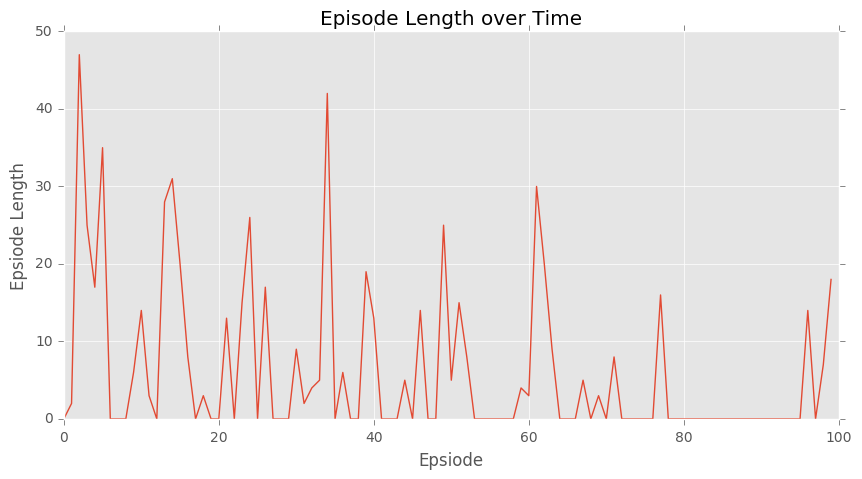

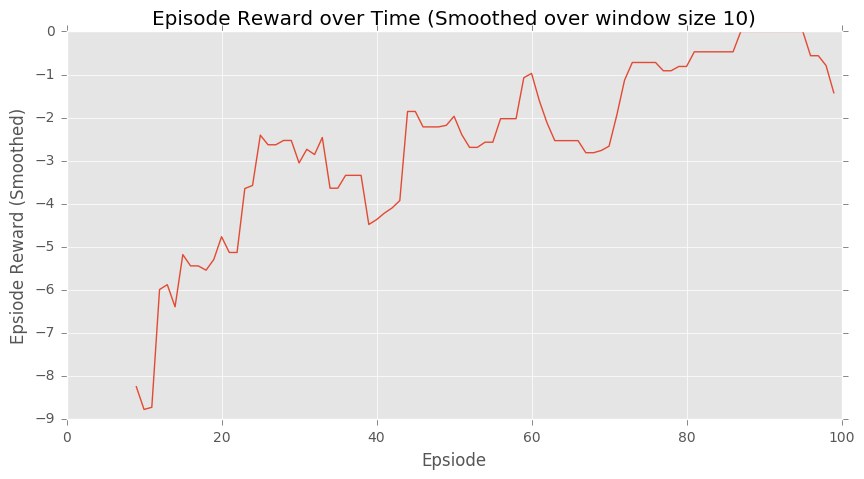

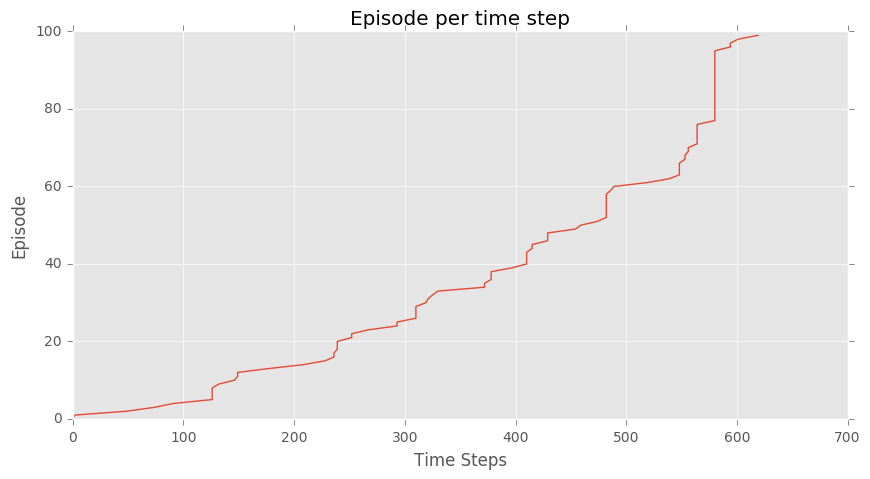

(<matplotlib.figure.Figure at 0x7f0f50034b10>,
 <matplotlib.figure.Figure at 0x7f0e78067350>)

In [9]:
plotting.plot_episode_stats(stats, smoothing_window=10)